In this page we will continue from the LinearExample notebook, choosing to use the covariance summary statistics for the linear example. We will use a custom class to aim to increase customisability as well as trying to use dropout to get a distribution of outputs.

### Imports

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_probability as tfp
from scipy.stats import truncnorm

tfd = tfp.distributions

print("Successfully imported all modules")

Successfully imported all modules


### All Parameters

Can change the parameters here and re-run

In [66]:
no_params = 10
epochs = 200
patience_early_stopping = 10  # Early-stopping window
neurons_per_layer = [128, 128]
dropout_probs = [0.2, 0.2]
always_on_dropout = True  # Keep dropout active at test time

batch_size = 256  # tf.data batch size
theta_range = (0.0, 10.0)
n_per_sample = 1000  # points (x, y) per simulated data-set
noise_std = 0.5
n_examples = 20_000  # simulated data-sets to learn from

# evaluation
no_test_samples = 10_000
mc_samples = 50  # Monte-Carlo dropout passes

### plot helper function

In [67]:
def plot_loss(history: tf.keras.callbacks.History,
              title: str = "Loss curve") -> None:
    """Plot training & validation loss curves (linear + semilog-y).
    Generates two stacked panels:
       • top: linear y-axis
       • bottom: semilog-y (base-10) axis """
    epochs = range(1, len(history.history["loss"]) + 1)

    fig, (ax_lin, ax_log) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # linear plot
    ax_lin.plot(epochs, history.history["loss"], label="train")
    ax_lin.plot(epochs, history.history["val_loss"], label="val")
    ax_lin.set_ylabel("MSE")
    ax_lin.set_title(title + " (linear scale)")
    ax_lin.legend()
    ax_lin.grid(True, which="both", linestyle="--", linewidth=0.5)

    # semilog-y plot
    ax_log.semilogy(epochs, history.history["loss"], label="train")
    ax_log.semilogy(epochs, history.history["val_loss"], label="val")
    ax_log.set_xlabel("Epoch")
    ax_log.set_ylabel("MSE (log scale)")
    ax_log.set_title(title + " (semilogy)")
    ax_log.legend()
    ax_log.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


### Custom NN

As before use keras.

Define our custom Neural Network, can add or remove layers accordingly

In [68]:
class NN(Model):
    """Two-layer MLP with optional always-on dropout."""

    def __init__(self,
                 no_params: int,
                 neurons: list,
                 dropout_probs: list,
                 always_on_dropout: bool = False):
        super(NN, self).__init__(name='NN')  # inherits the parent class and names it (for debugging)

        self.neurons = neurons
        self.no_params = no_params  # number of parameters we output
        self.always_on_dropout = always_on_dropout  # if true then we leave on for test passes

        # Define our layers - we will loop over creating the required hidden and dropout layers
        self.norm = tf.keras.layers.Normalization(axis=-1, name="input_norm")

        self.hidden_layers = []

        for size, p in zip(neurons, dropout_probs):
            self.hidden_layers.append(tf.keras.layers.Dense(size, activation="relu"))
            self.hidden_layers.append(tf.keras.layers.Dropout(rate=p))

        self.out = Dense(no_params, activation="linear", name="out")  # Applies linear activation

    def call(self,
             inputs: tf.Tensor,
             training: bool = False) -> tf.Tensor:
        """Forward pass with dropout flag logic."""
        dropout_flag = training or self.always_on_dropout

        # Apply our custom layers
        x = self.norm(inputs)
        # every second layer is a Dropout, so we toggle `training` only on those
        for layer in self.hidden_layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=dropout_flag)
            else:
                x = layer(x)
        return self.out(x)


### Dataset generation

We make a similar function to before with only the one covariance option.

The scaling helps significantly to get good convergence

In [69]:
def simulate_batch(no_params: int,
                   batch_size: int,
                   theta_range: tuple,
                   n_per_sample: int,
                   noise_std: float):
    """Simulate one batch of (summary, θ, 1) pairs."""
    # Generate our theta, and random points which will be used to form the output variable
    theta = tf.random.uniform([batch_size, no_params, 1], *theta_range)  # (B, D, 1)
    X = tf.random.uniform([batch_size, n_per_sample, no_params])  # (B, n, D)

    # Generate noise and then create output variable
    noise = noise_std * tf.random.normal([batch_size, n_per_sample, 1])  # (B, n, 1)
    y = tf.matmul(X, theta) + noise  # (B, n, 1)

    mean_x = tf.reduce_mean(X, axis=1)  # (B, D)
    mean_y = tf.reduce_mean(y, axis=1)  # (B, 1)

    # Center both x and y around their mean
    xc = X - tf.expand_dims(mean_x, 1)
    yc = y - tf.expand_dims(mean_y, 1)

    # Create the covariance matrix for the data, then the covariance between x and y
    cov_x = tf.matmul(xc, xc, transpose_a=True) / n_per_sample  # (B, D, D)
    cov_xy = tf.matmul(xc, yc, transpose_a=True) / n_per_sample  # (B, D, 1)

    summary = tf.concat([
        mean_x,
        mean_y,
        tf.reshape(cov_x, [-1, no_params * no_params]),
        tf.reshape(cov_xy, [-1, no_params]),
    ], axis=-1)  # (B, D² + 2D + 1)

    return summary, theta


def make_dataset_multi_dim(n_examples: int,
                           no_params: int,
                           batch_size: int,
                           noise_std: float) -> tf.data.Dataset:
    """Create a tf.data pipeline emitting un-batched (summary, θ) pairs."""
    steps = n_examples // batch_size
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch(no_params,
                                 batch_size,
                                 theta_range,
                                 n_per_sample,
                                 noise_std),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)


In [70]:
train_ds = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.9),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std
)
val_ds = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.1),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std
)

Now initialise the model defining the optimiser too

In [71]:
input_size = no_params ** 2 + 2 * no_params + 1

myNN = NN(neurons=neurons_per_layer,
          no_params=no_params,
          dropout_probs=dropout_probs,
          always_on_dropout=always_on_dropout)

myNN.norm.adapt(train_ds.map(lambda x, y: x))

myNN.compile(loss='mse', optimizer="adam")

2025-06-26 11:10:16.734895: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fit the model

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1731 - val_loss: 7.0615
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3129 - val_loss: 4.0061
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4572 - val_loss: 2.4024
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2666 - val_loss: 1.9268
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9086 - val_loss: 1.7553
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7419 - val_loss: 1.6227
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5963 - val_loss: 1.5342
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5127 - val_loss: 1.4284
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4255 - val_loss: 1.3993
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3723 - val_loss: 1.3325
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3148 - val_loss: 1.3182
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

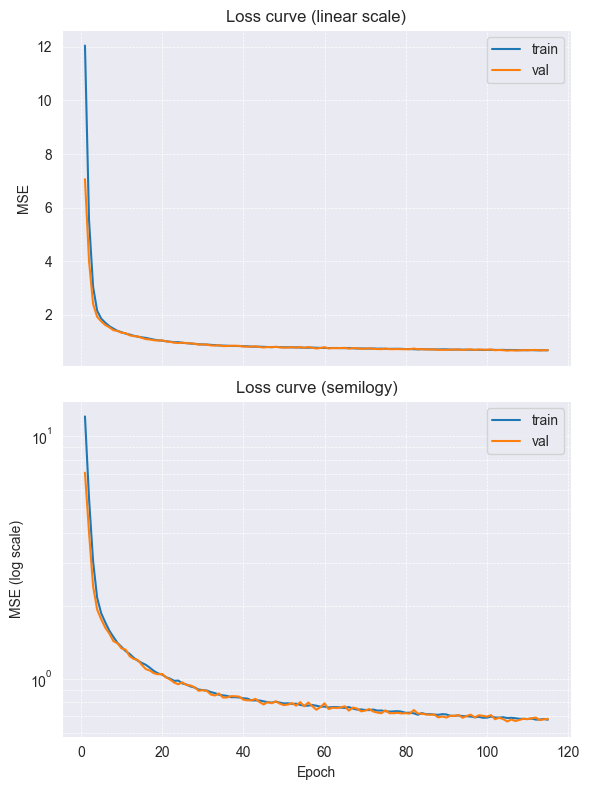

In [72]:
history = myNN.fit(
    train_ds.batch(batch_size),
    validation_data=val_ds.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
myNN.summary()
plot_loss(history)

### Results

Now we look to see how it performs on the data, as mentioned we keep dropout on during testing and will take a point estimate

In [73]:
def average_relative_error(model: tf.keras.Model,
                           batchsize: int,
                           no_tests: int,
                           mc_samples: int,
                           n_per_sample: int,
                           noise_std: float,
                           theta_range: tuple) -> float:
    """Estimate mean relative error with Monte-Carlo dropout."""
    # Simulate a fresh batch
    summaries, theta_true = simulate_batch(
        no_params,
        batch_size=no_tests,
        theta_range=theta_range,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )  # shapes: (N, ·) and (N, D, 1)
    theta_true_np = np.squeeze(theta_true.numpy(), axis=-1)  # (N, D)

    # Monte-Carlo dropout passes
    preds = [
        model.predict(summaries, batch_size=batchsize, verbose=0)
        for _ in range(mc_samples)
    ]
    theta_pred_mean = np.mean(np.stack(preds, axis=0), axis=0)  # (N, D)

    # compute the relative error
    eps = 1e-8
    diff = theta_pred_mean - theta_true_np  # (N, D)
    numer = np.linalg.norm(diff, axis=1)  # ‖θ̂ – θ‖₂
    denom = np.linalg.norm(theta_true_np, axis=1) + eps
    return (numer / denom).mean()


In [74]:
avg_re = average_relative_error(
    model=myNN,
    batchsize=batch_size,
    no_tests=no_test_samples,
    mc_samples=mc_samples,
    n_per_sample=n_per_sample,
    noise_std=noise_std,
    theta_range=theta_range
)
print(f"Average relative error (MC-{mc_samples}): {avg_re:.4f}")

Average relative error (MC-50): 0.0636


### Histogram of posterior distributions for each theta for one specific run

We will now create an example with a histogram for each of our theta parameters and its true value.

In [75]:
def simulate_batch_raw(no_params: int,
                       batch_size: int,
                       theta_range: tuple,
                       n_per_sample: int,
                       noise_std: float):
    """Same as `simulate_batch` but also returns X and y."""
    theta = tf.random.uniform([batch_size, no_params, 1], *theta_range)  # (B, D, 1)
    X = tf.random.uniform([batch_size, n_per_sample, no_params])  # (B, n, D)
    noise = noise_std * tf.random.normal([batch_size, n_per_sample, 1])  # (B, n, 1)
    y = tf.matmul(X, theta) + noise  # (B, n, 1)

    mean_x = tf.reduce_mean(X, axis=1)
    mean_y = tf.reduce_mean(y, axis=1)
    xc = X - tf.expand_dims(mean_x, 1)
    yc = y - tf.expand_dims(mean_y, 1)
    cov_x = tf.matmul(xc, xc, transpose_a=True) / n_per_sample
    cov_xy = tf.matmul(xc, yc, transpose_a=True) / n_per_sample

    summary = tf.concat([
        mean_x,
        mean_y,
        tf.reshape(cov_x, [-1, no_params * no_params]),
        tf.reshape(cov_xy, [-1, no_params])
    ], axis=-1)

    return summary, theta, X, y


def posterior_mean_cov(X, y, sigma2):
    """Return μ, Σ of the Gaussian part of the posterior."""
    XtX_inv = tf.linalg.inv(tf.matmul(X, X, transpose_a=True))  # (D,D)
    mu = tf.matmul(XtX_inv, tf.matmul(X, y, transpose_a=True))  # (D,1)
    Sigma = sigma2 * XtX_inv
    return tf.squeeze(mu).numpy(), Sigma.numpy()  # (D,), (D,D)


def plot_single_dataset_posterior(model: tf.keras.Model,
                                  *,
                                  no_params: int = no_params,
                                  n_per_sample: int = n_per_sample,
                                  noise_std: float = noise_std,
                                  theta_range: tuple = theta_range,
                                  mc_samples: int = mc_samples,
                                  bins: int = 30,
                                  cmap: str = "tab10") -> None:
    """
    One data-set → many MC-dropout draws → θ histograms
    + overlay of the generative Normal(θ_true, σ²) density.
    The x-axis is fixed to [θ_min - 2,  θ_max + 2]
    """
    # simulate a single experiment  also return raw X, y needed to calculate posterior
    summaries, theta_true, X_raw, y_raw = simulate_batch_raw(
        no_params=no_params,
        batch_size=1,
        theta_range=theta_range,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )
    theta_true = theta_true.numpy().squeeze(-1).flatten()

    # analytic Gaussian posterior, given (X, y)
    mu_post, Sigma_post = posterior_mean_cov(
        X_raw[0],  # (n, D)
        y_raw[0],  # (n, 1)
        sigma2=noise_std ** 2,
    )

    # MC draws
    preds = [
        model.predict(summaries, verbose=0)[0]  # (D,)
        for _ in range(mc_samples)
    ]
    preds = np.stack(preds, axis=0)  # (K, D)

    # set-up plot
    n_rows, n_cols = 2, 5
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3, n_rows * 3.5),
        squeeze=False
    )

    # for each θ
    for j in range(n_rows * n_cols):
        r, c = divmod(j, n_cols)
        ax = axes[r, c]
        xmin, xmax = theta_range[0] - 2, theta_range[1] + 2
        ax.set_xlim(xmin, xmax)

        if j < no_params:
            # histogram of MC–dropout draws
            ax.hist(
                preds[:, j],
                bins=bins,
                color="lightsteelblue",
                edgecolor="k",
                alpha=0.75,
                density=True
            )

            # overlay analytic 1‑D marginal of posterior θ_j | X, y  (Gaussian)
            sigma_j = np.sqrt(Sigma_post[j, j])
            xx = np.linspace(xmin, xmax, 250)
            pdf = (1.0 / (np.sqrt(2 * np.pi) * sigma_j)) * \
                  np.exp(-0.5 * ((xx - mu_post[j]) / sigma_j) ** 2)
            ax.plot(xx, pdf,
                    color="limegreen",
                    linewidth=2.0,
                    label=r"$p(\theta_j\,|\,X,y)$")

            # aesthetics
            ax.set_title(f"θ{j + 1}")
            if c == 0:
                ax.set_ylabel("density")
            ax.grid(alpha=0.3, linestyle="--")
            ax.legend(fontsize=7)
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


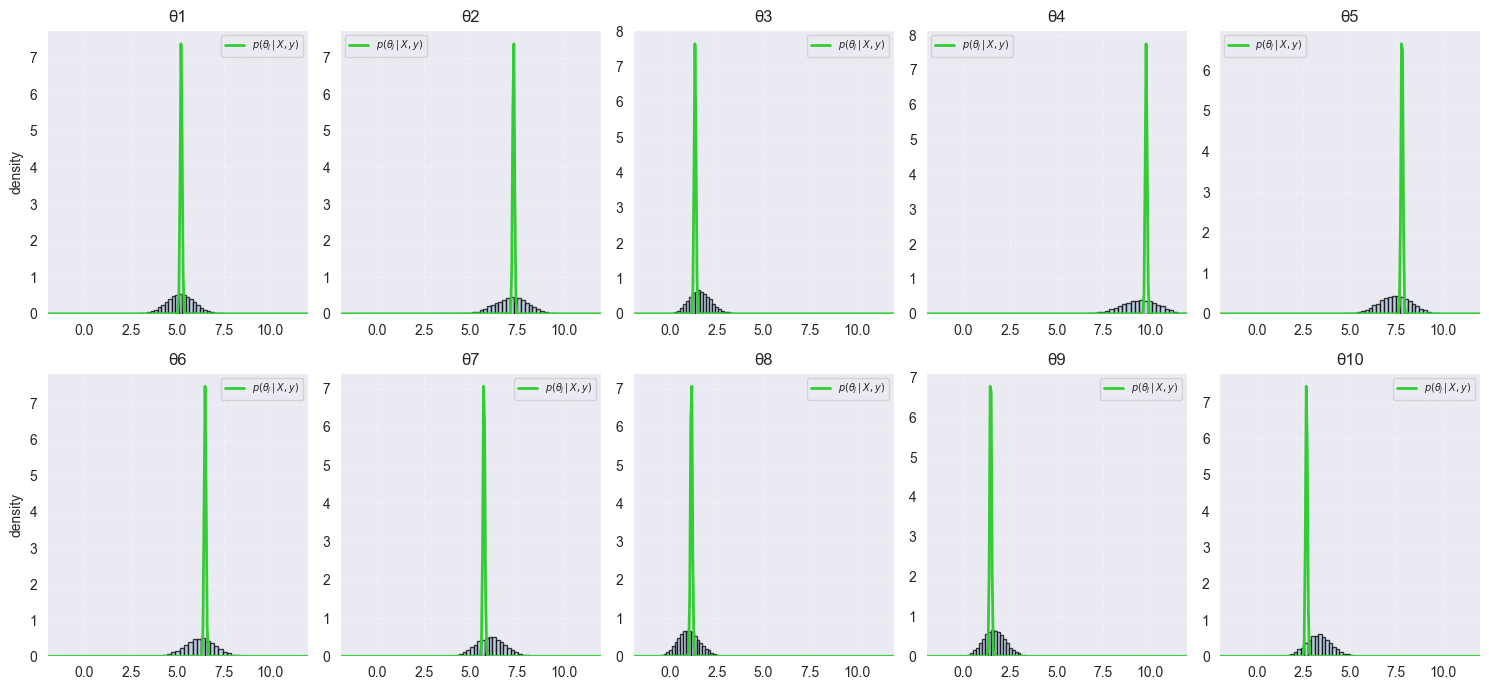

In [76]:
plot_single_dataset_posterior(model=myNN, mc_samples=10_000, noise_std=noise_std)


### Results

In general does a pretty decent job at capturing the symmetry and mean of each of the parameter values however we notice it does over estimate the standard deviation of our

### Things we can do

We could also further investigate how this changes with a range of different paramaters at the start

We need to also investigate the affect when our noise is not symmetric?

Plot confidence intervals compare to the initial variance of noise

Try generating theta from different distributions pehaps non independent?

Clip the values using a sigmoid?







### Adjust the noise parameter to see if can pick up on it

Epoch 1/200


2025-06-26 11:13:24.904888: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4997 - val_loss: 7.2419
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5393 - val_loss: 4.2131
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5922 - val_loss: 2.4320
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2911 - val_loss: 2.0578
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9431 - val_loss: 1.7449
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7242 - val_loss: 1.6735
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5776 - val_loss: 1.5294
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4883 - val_loss: 1.4457
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4312 - val_loss: 1.3963
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3741 - val_loss: 1.3322
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3225 - val_loss: 1.2896
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2757 - val_l

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

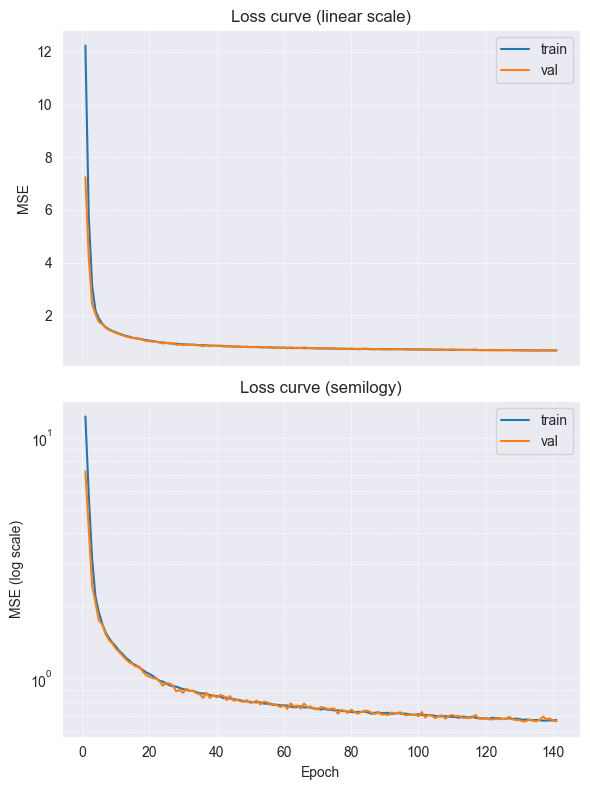

In [77]:
noise_std = 1

train_ds2 = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.9),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std
)
val_ds2 = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.1),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std
)

myNN2 = NN(neurons=neurons_per_layer,
           no_params=no_params,
           dropout_probs=dropout_probs,
           always_on_dropout=always_on_dropout)

myNN2.norm.adapt(train_ds2.map(lambda x, y: x))

myNN2.compile(loss='mse', optimizer="adam")

history2 = myNN2.fit(
    train_ds2.batch(batch_size),
    validation_data=val_ds2.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
myNN2.summary()
plot_loss(history2)

Average relative error (MC-50): 0.0659


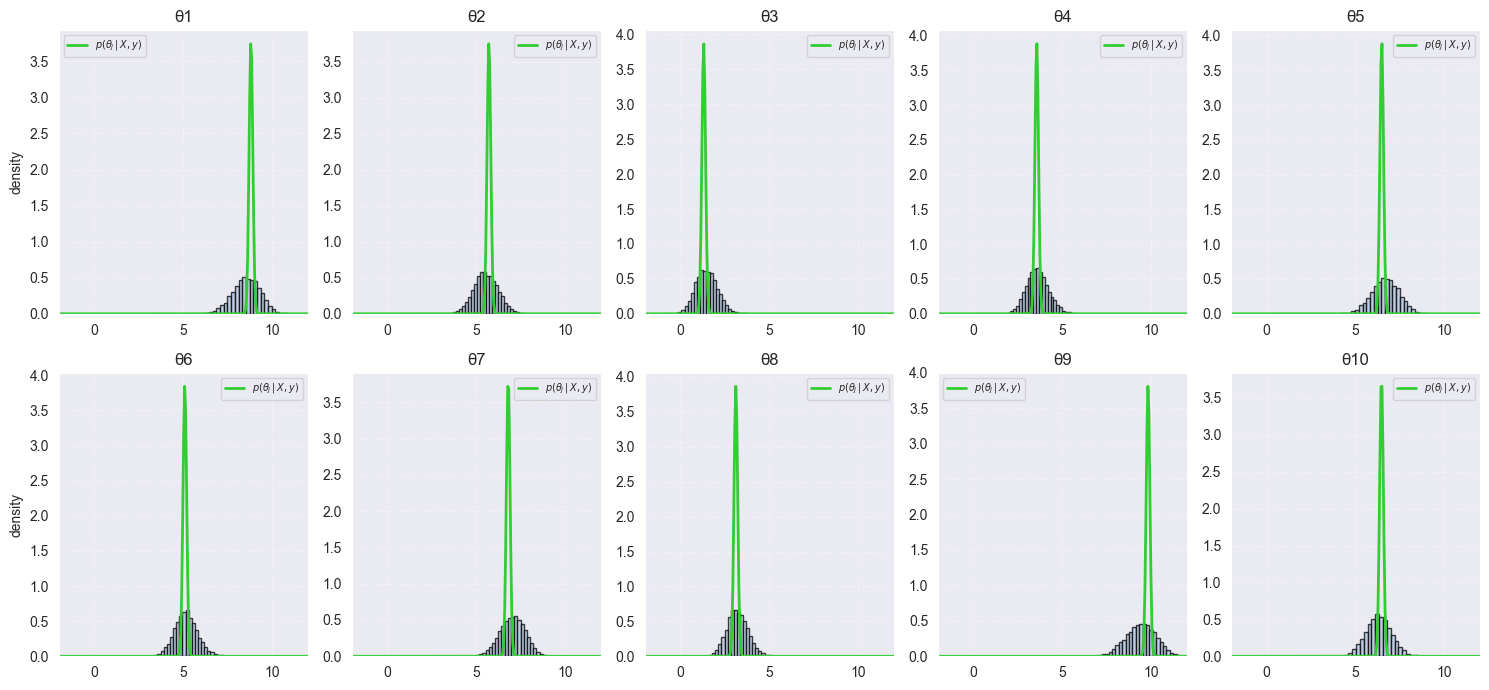

In [78]:
avg_re = average_relative_error(
    model=myNN2,
    batchsize=batch_size,
    no_tests=no_test_samples,
    mc_samples=mc_samples,
    n_per_sample=n_per_sample,
    noise_std=noise_std,
    theta_range=theta_range
)
print(f"Average relative error (MC-{mc_samples}): {avg_re:.4f}")

plot_single_dataset_posterior(model=myNN2, mc_samples=10000, noise_std=noise_std)

### How often does each value of theta get picked

In [79]:
def plot_posterior_vs_prior(model: tf.keras.Model,
                            *,
                            no_params: int = no_params,
                            n_per_sample: int = n_per_sample,
                            noise_std: float = noise_std,
                            theta_range: tuple = theta_range,
                            mc_samples: int = mc_samples,
                            num_tests: int = no_test_samples,
                            bins: int = 40,
                            cmap: str = "tab10") -> None:
    """
    Many data-sets → many MC-dropout draws → θ histograms
    + overlay of the Uniform prior on [θ_min, θ_max].
    """
    summaries, _ = simulate_batch(
        no_params=no_params,
        batch_size=num_tests,
        theta_range=theta_range,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )

    preds = np.stack(
        [model.predict(summaries, verbose=0) for _ in range(mc_samples)],
        axis=0,  # (K, N, D)
    ).reshape(-1, no_params)  # ((K·N), D)

    n_rows, n_cols = 2, 5
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3, n_rows * 3.5),
        squeeze=False
    )

    θ_min, θ_max = theta_range

    for j in range(n_rows * n_cols):
        r, c = divmod(j, n_cols)
        ax = axes[r, c]
        ax.set_xlim(θ_min - 2, θ_max + 2)

        if j < no_params:
            ax.hist(preds[:, j],
                    bins=bins,
                    color="lightsteelblue",
                    edgecolor="k",
                    alpha=0.75,
                    density=True)

            # Uniform prior height
            ax.hlines(1 / (θ_max - θ_min),
                      xmin=θ_min, xmax=θ_max,
                      color="limegreen", linewidth=2.5,
                      label="Uniform prior")

            ax.set_title(f"θ{j + 1}")
            if c == 0:
                ax.set_ylabel("density")
            ax.grid(alpha=0.3, linestyle="--")
            ax.legend(fontsize=7)
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


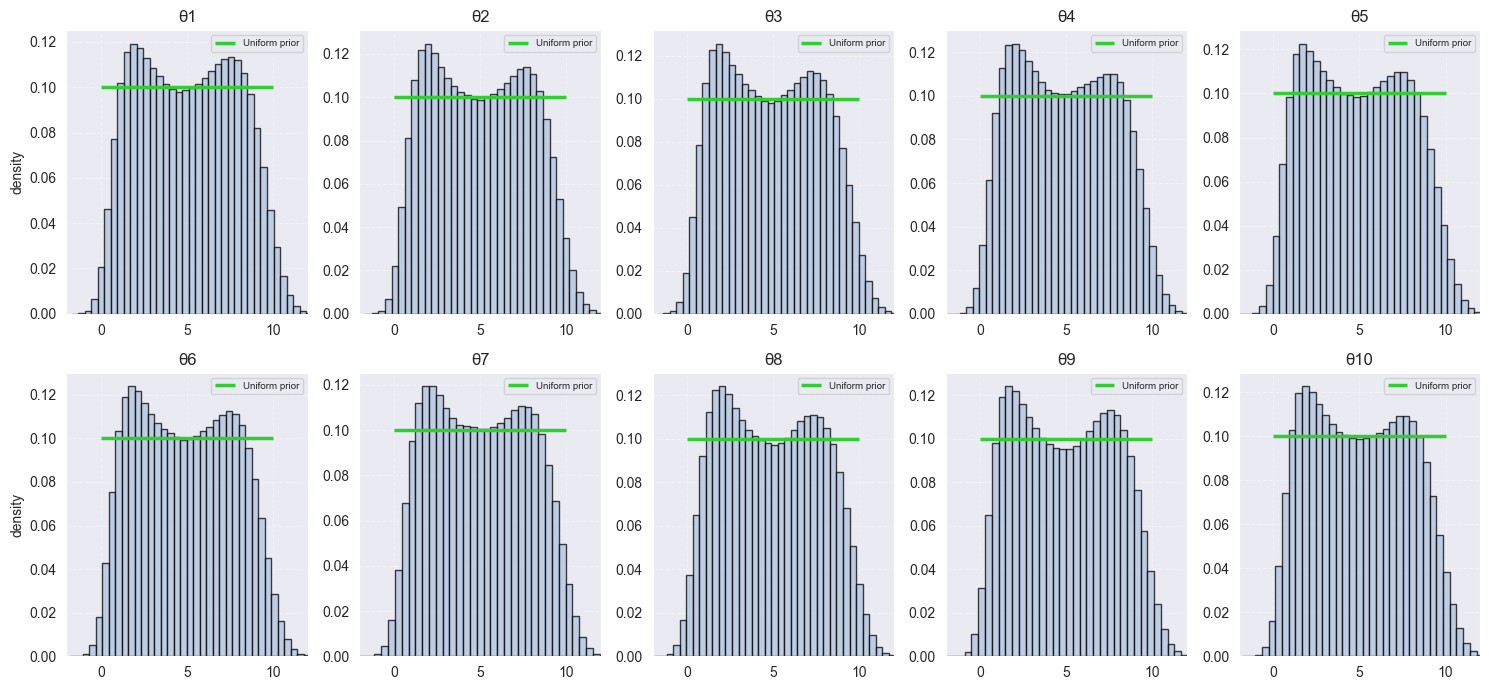

In [80]:
plot_posterior_vs_prior(model=myNN,
                        mc_samples=500,
                        num_tests=10_000,
                        bins=40)

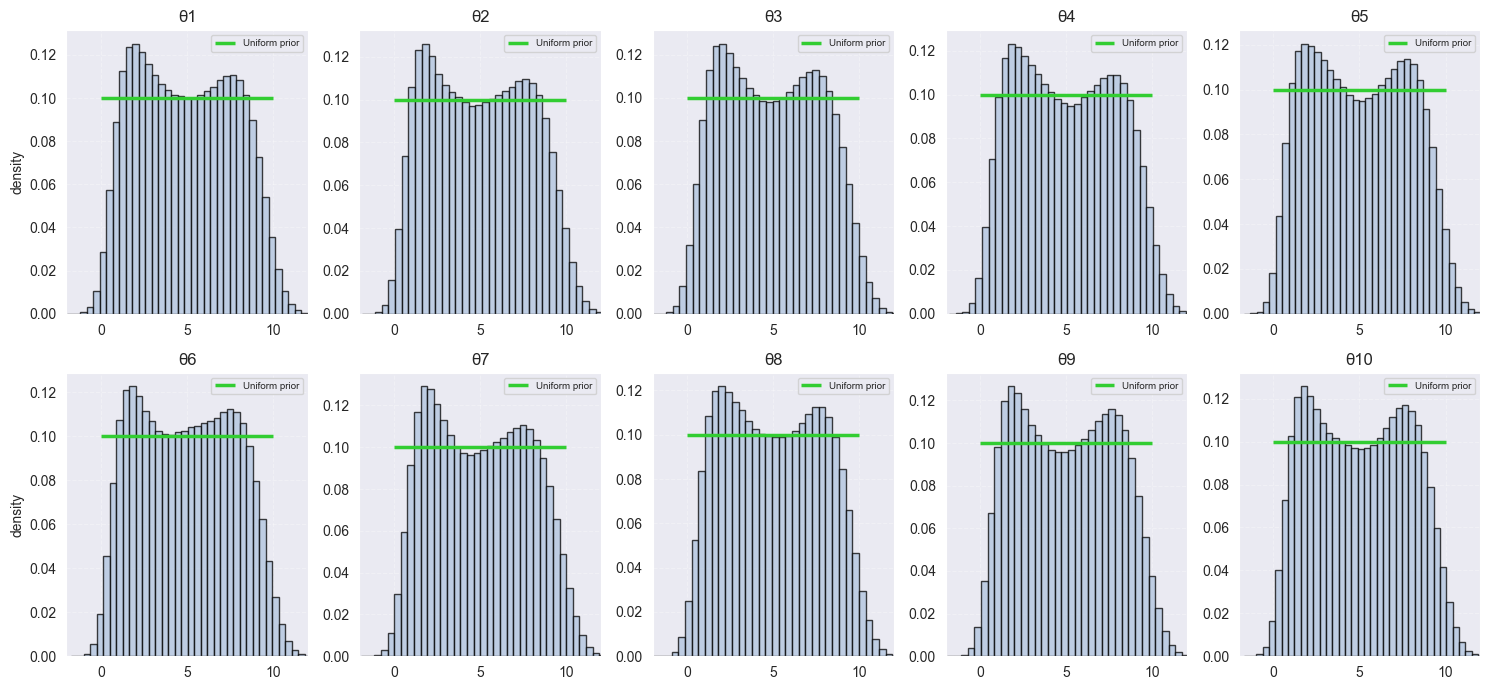

In [81]:
plot_posterior_vs_prior(model=myNN2,
                        mc_samples=500,
                        num_tests=10_000,
                        bins=40)

For these plots I have ran it over several thousand samples. and then summed all the density for each of the bins before normalising so that it amounts to a probability density.

We would expect each bin to have mass approximately 0.1 within the region from which we draw the sample. However what we see is that our model has more mass in the regions 2-4 and 6-8 whilst significantly less in the boundary regions.

We notice that 0.5 is chosen closest to the right number of times in each theta.

This suggests perhaps our model is not appropriately calibrated.

### Add an extra layer and increase width to see if improves


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.2843 - val_loss: 6.8101
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9355 - val_loss: 3.3691
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0045 - val_loss: 2.5035
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3965 - val_loss: 2.1412
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0994 - val_loss: 1.9638
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8503 - val_loss: 1.7383
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7047 - val_loss: 1.6386
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6027 - val_loss: 1.5947
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5288 - val_loss: 1.4340
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4290 - val_loss: 1.4006
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3580 - val_loss: 1.3401
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,723 (971.58 KB)

 Trainable params: 82,826 (323.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 165,654 (647.09 KB)

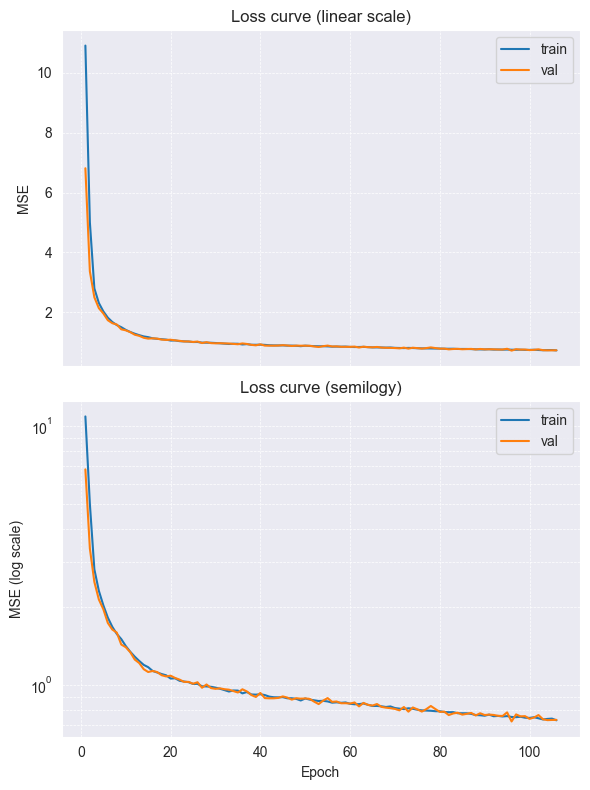

In [82]:
neurons_per_layer = [128, 256, 128]
dropout_probs = [0.2, 0.1, 0.2]
noise_std = 0.5

myNN3 = NN(neurons=neurons_per_layer,
           no_params=no_params,
           dropout_probs=dropout_probs,
           always_on_dropout=always_on_dropout)

myNN3.norm.adapt(train_ds.map(lambda x, y: x))
myNN3.compile(loss='mse', optimizer="adam")

history3 = myNN3.fit(
    train_ds.batch(batch_size),
    validation_data=val_ds.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
myNN3.summary()
plot_loss(history3)

Average relative error (MC-50): 0.0668


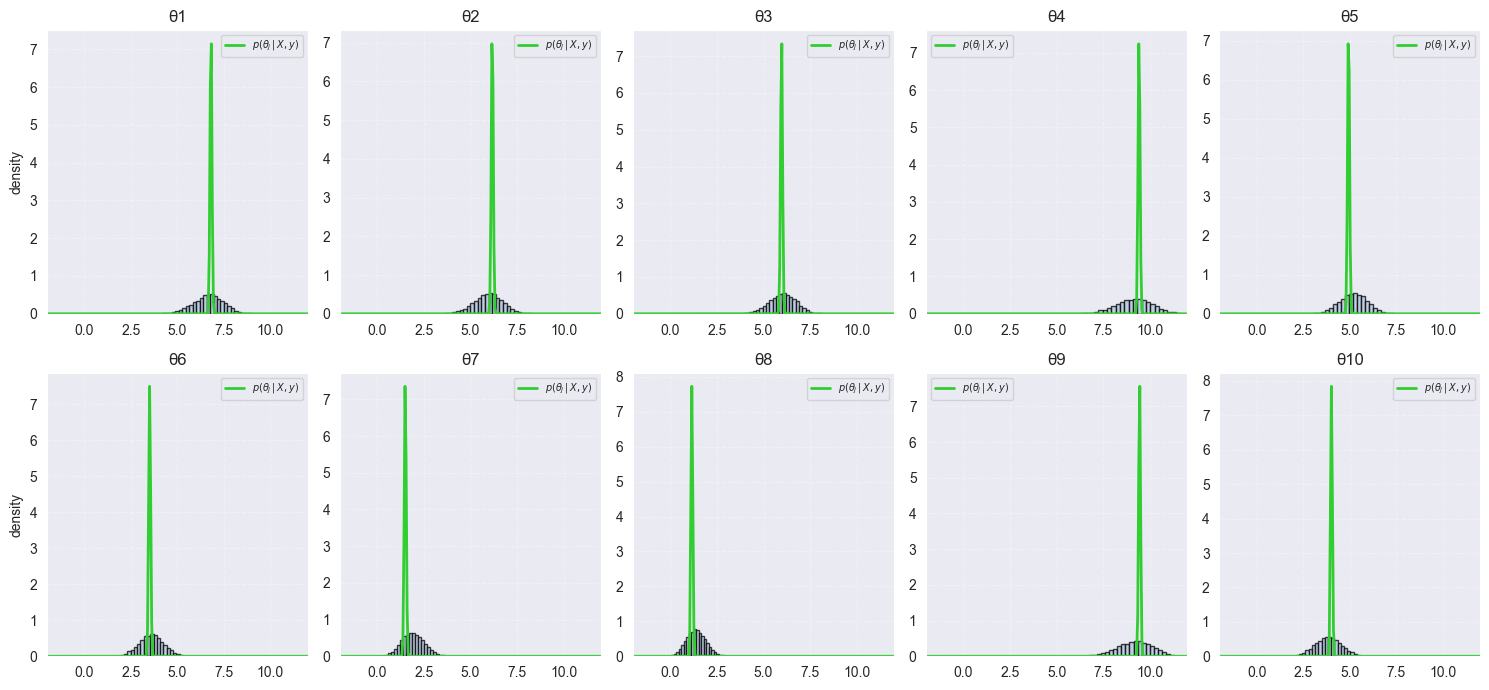

In [83]:
avg_re = average_relative_error(
    model=myNN3,
    batchsize=batch_size,
    no_tests=no_test_samples,
    mc_samples=mc_samples,
    n_per_sample=n_per_sample,
    noise_std=noise_std,
    theta_range=theta_range
)
print(f"Average relative error (MC-{mc_samples}): {avg_re:.4f}")

plot_single_dataset_posterior(model=myNN3, mc_samples=10000, noise_std=noise_std)

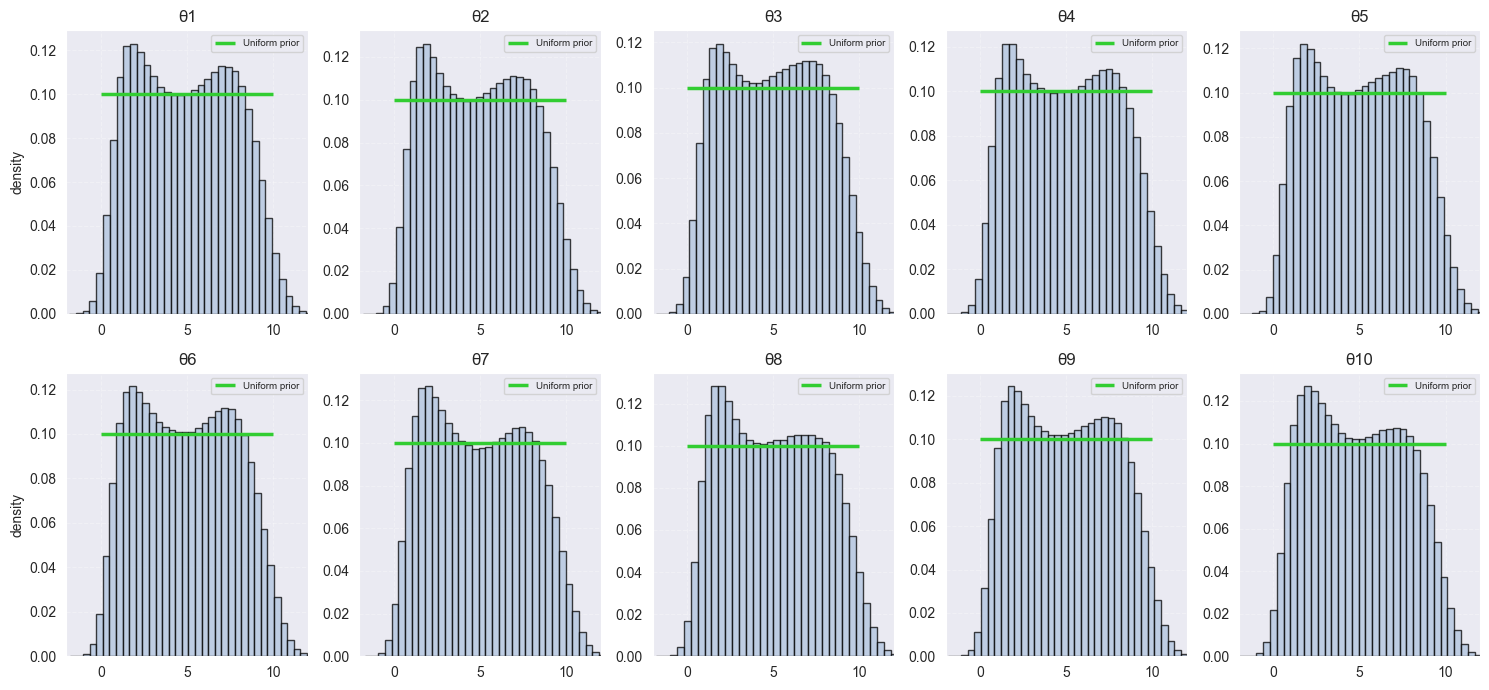

In [84]:
plot_posterior_vs_prior(model=myNN3,
                        mc_samples=500,
                        num_tests=10_000,
                        bins=40)

### Results

We see no visible improvement for the fitting of the approximated posterior to the true from before. We do see that again the mean is well approximated but the std is far too large.

Since making the network larger made no improvement this perhaps the issue lies elsewhere. Perhaps in the selection of summary statistics we use?

We see higher levels of uncertainty towards the edge of regions

### Raw data vs chosen theta

We aim to see how well it approximates each theta.

In [87]:
def plot_partial_scatter_with_mc_bands(model: tf.keras.Model,
                                       *,
                                       no_params: int = no_params,
                                       n_per_sample: int = n_per_sample,
                                       noise_std: float = noise_std,
                                       theta_range: tuple = theta_range,
                                       mc_samples: int = mc_samples,
                                       point_size: int = 10) -> None:
    """
    One data-set → 10 panels
        • x-axis: x_j
        • y-axis: partial residual y_i – ∑_{k≠j} θ̂_k x_ik
      Overlays:
        • green  : y = θ_true x
        • orange : y = θ̄ x ± 1 σ (MC-dropout)
    """

    # simulate a single data-set
    summary, theta_true, X_raw, y_raw = simulate_batch_raw(
        no_params=no_params,
        batch_size=1,
        theta_range=theta_range,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )
    theta_true = theta_true.numpy().squeeze()  # (D,)
    X_raw = X_raw[0].numpy()  # (n, D)
    y_raw = y_raw[0].numpy().squeeze()  # (n,)

    # MC-dropout draws then get posterior mean/std
    mc_draws = np.stack([model.predict(summary, verbose=0)[0]
                         for _ in range(mc_samples)], axis=0)  # (K,D)
    theta_mean = mc_draws.mean(axis=0)  # (D,)
    theta_std = mc_draws.std(axis=0)  # (D,)

    # plotting
    n_rows, n_cols = 2, 5
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols * 4, n_rows * 3.5), squeeze=False)

    for j in range(no_params):
        r, c = divmod(j, n_cols)
        ax = axes[r, c]

        # compute residuals that isolate the j-th slope
        y_res_true = y_raw - (X_raw @ theta_true) + theta_true[j] * X_raw[:, j]
        y_res_pred = y_raw - (X_raw @ theta_mean) + theta_mean[j] * X_raw[:, j]

        # scatter of residuals vs x_j
        ax.scatter(X_raw[:, j], y_res_true,
                   s=point_size, alpha=0.35,
                   color="steelblue", edgecolors="none")

        # x-grid for straight lines
        xmin, xmax = X_raw[:, j].min(), X_raw[:, j].max()
        xx = np.linspace(xmin, xmax, 200)

        # true and MC-mean lines
        ax.plot(xx, theta_true[j] * xx,
                color="green", linewidth=2, label=r"$y=\theta^{\mathrm{true}}x$")
        ax.plot(xx, theta_mean[j] * xx,
                color="darkorange", linewidth=2, label=r"$y=\bar\theta\,x$")

        # ±1σ band from MC posterior
        upper = (theta_mean[j] + theta_std[j]) * xx
        lower = (theta_mean[j] - theta_std[j]) * xx
        ax.fill_between(xx, lower, upper,
                        color="darkorange", alpha=0.20, label=r"$\pm1\sigma$")

        ax.set_title(f"θ{j + 1}")
        ax.set_xlabel(f"x{j + 1}")
        if c == 0:
            ax.set_ylabel("partial y")
        ax.grid(alpha=0.3, linestyle="--")

    # one shared legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center",
               ncol=3, frameon=False, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


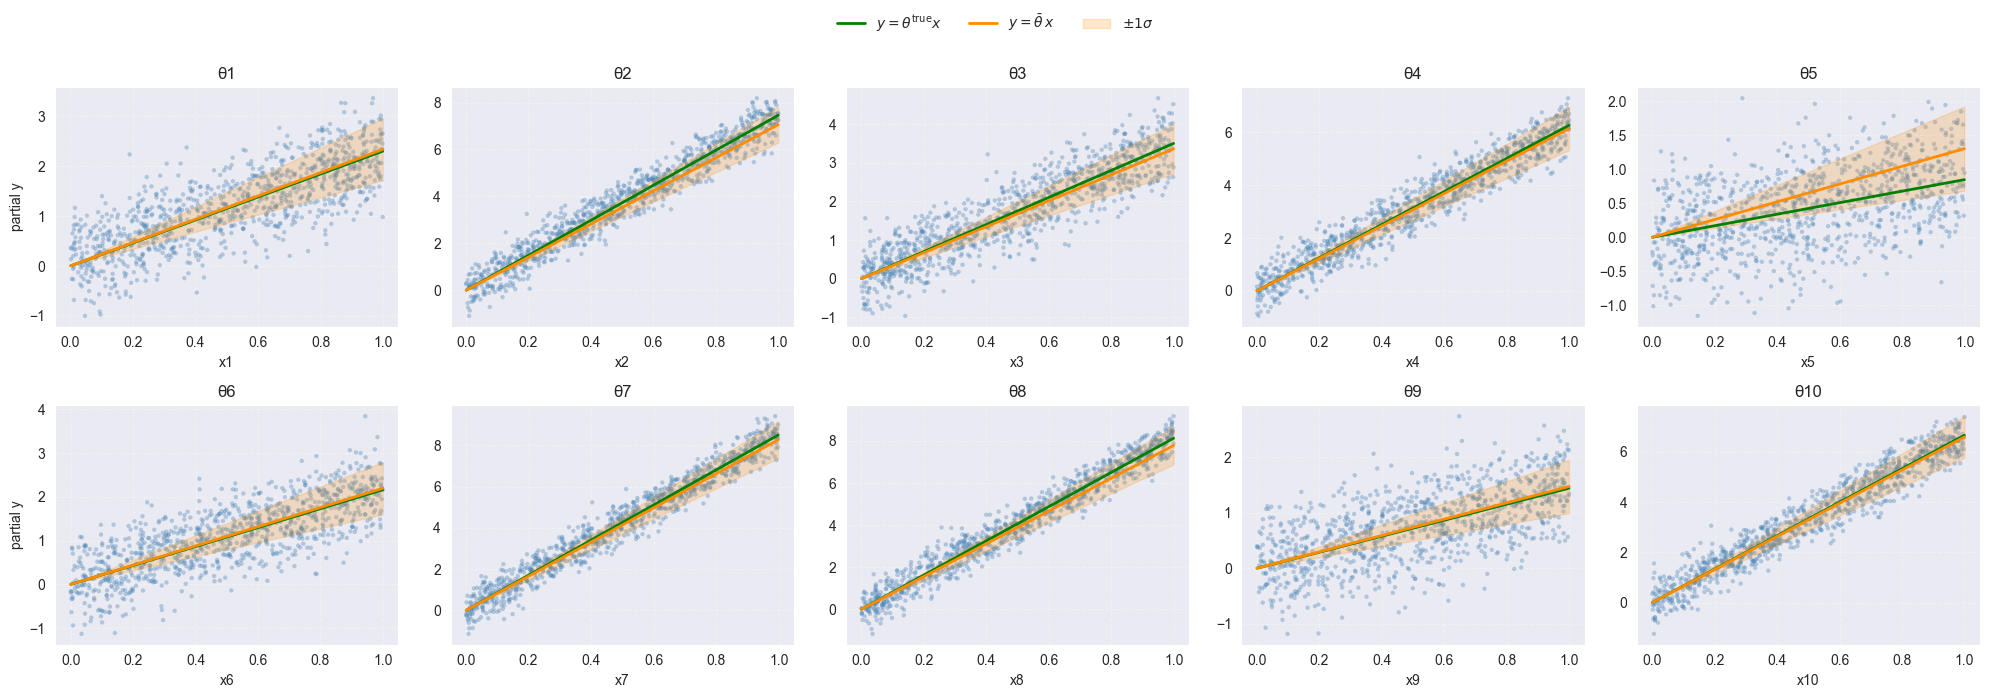

In [88]:
plot_partial_scatter_with_mc_bands(myNN, mc_samples=1_000)


Can see overall does a pretty good job of estimating the point. With some having significantly tighter confidence intervals.